# We want to know if pretraining on spectral ordering is better than just downloading ImageNet weights

In [1]:
gpus = [1]
import os
os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(i) for i in gpus])

In [2]:
import tensorflow as tf
# tf.enable_eager_execution()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from glob import glob
import pickle
from tensorflow.keras import layers, Sequential, datasets, models, losses, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import datetime
import sys
from tensorflow.keras.backend import clear_session
from trainingfuncs import *
from math_utils import *

In [3]:
tf.compat.v1.disable_eager_execution()

# Load data

In [4]:
sys.path.append("..") # Adds higher directory to python modules path.
from helpers.dataset_vars import *
from helpers.myclasses import *

In [5]:
dataset = Dataset('Starling')
analysis = 'stable_length'

In [6]:
results_folder = os.path.abspath('/mnt/cube/kai/results/sound_texture/classifier')
species_folder = dataset.path_save
analysis_folder = os.path.join(species_folder, analysis)
log_folder = os.path.join(analysis_folder, 'log')

In [7]:
spec_file = sorted(glob(os.path.join(log_folder, 'all_specs_star.p')))[-1]

In [8]:
spec_df = pickle.load(open(spec_file, 'rb'))

In [9]:
spec_df.tail()

,name,wav,spec
6995,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.8473503, -0.74000514, -0.6745358, -0.6307..."
6996,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.618756, -0.6190624, -0.6269182, -0.641789..."
6997,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.39242423, -0.3716945, -0.35015196, -0.346..."
6998,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.71081, -0.7151853, -0.5816425, -0.5211242..."
6999,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.63244075, -0.59842235, -0.56845856, -0.55..."


In [10]:
subjs = sorted(spec_df.name.value_counts().keys().tolist())

In [11]:
spec_h, spec_w = spec_df.spec[0].shape
print(spec_h, spec_w)

291 707


In [12]:
spec_list = spec_df.spec.values.tolist()

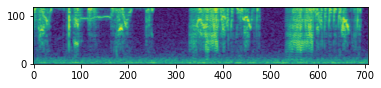

In [13]:
plt.imshow(spec_list[0][:120,:], origin='lower')

In [14]:
subj_list = spec_df.name.values.tolist()

In [15]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
output_data = enc.fit_transform(np.array(subj_list).reshape((len(subj_list), 1))).toarray()

In [16]:
import itertools
output_data = np.array(list(itertools.chain.from_iterable(itertools.repeat(x, 3) for x in output_data)))

In [17]:
np.unique(output_data, return_counts=True, axis=0)

(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 array([1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500,


In [18]:
input_list = []
for spec in spec_list:
    spec_h, spec_w = spec.shape
    divided_w = spec_w//3
    for i in range(3):
        s = spec[:, divided_w*i:divided_w*(i+1)]
        input_list.append(np.stack([s, s, s], axis = 2))

In [19]:
input_list = np.array(input_list)

In [20]:
input_list.shape

(21000, 291, 235, 3)

In [21]:
n_samples, n_outputs=output_data.shape
h, w = input_list[0].shape[:2]
print(n_samples, n_outputs, h, w)

21000 14 291 235


In [22]:
input_train, input_test, output_train, output_test = train_test_split(input_list, output_data, test_size = 0.2, 
                                                                      random_state=20, stratify=output_data)

In [23]:
input_train = np.array(input_train)
input_test = np.array(input_test)
output_train = np.array(output_train)
output_test = np.array(output_test)

## make model

In [24]:
clear_session()

In [25]:
model=self_VGG(weights='imagenet', trainable=False)

In [26]:
model_inputs = Input(shape=(h, w, 3))
resized = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear")(model_inputs)
dense_1 = layers.Dense(2048, name='dense1', activation='relu')(model(resized))
dropout_1 = layers.Dropout(0.2)(dense_1)
dense_2 = layers.Dense(2048, name='dense2', activation='relu')(dropout_1)
dropout_2 = layers.Dropout(0.2)(dense_2)
dense_3 = layers.Dense(1024, name='dense3', activation='relu')(dropout_2)
dropout_3 = layers.Dropout(0.2)(dense_3)
model_output = layers.Dense(n_outputs, name='output', activation ='softmax')(dropout_3) # this needs to be changed for both temporal and spectral slices
classifier = Model(model_inputs, model_output)

In [27]:
classifier.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 291, 235, 3)]     0         
_________________________________________________________________
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 512)               20024384  
_________________________________________________________________
dense1 (Dense)               (None, 2048)              1050624   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense2 (Dense)               (None, 2048)              4196352   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)             

In [28]:
classifier.compile(loss='categorical_crossentropy', optimizer = Adam(0.00001), metrics=['accuracy'])

In [30]:
results_folder = os.path.abspath('/mnt/cube/kai/results/perceptual_loss')
run_folder = extend_folder(results_folder, '2021_07_14_21_46_52', 'subj_classification', 'imagenet_untrainable')
with open(os.path.join(run_folder, 'training.log'), 'w') as file:
    file.write('This is a model pretrained on imagenet labels, \n \
               fine tuned on subject classification (Starling), pretrained weights (ImageNet) are untrainable')

## Fit

In [31]:
patience = 20
batch_size = 32
epochs = 1000

In [32]:
weights_file = os.path.join(run_folder, 'weights-improvement.h5')
callbacks = [EarlyStopping(monitor='val_accuracy', patience=patience, verbose=1),
            ModelCheckpoint(filepath=weights_file, monitor='val_accuracy', save_best_only=True, verbose=0)]

classifier.fit(x = input_train, y = output_train, callbacks=callbacks, epochs=epochs, 
          batch_size=batch_size,validation_split=0.1)

Train on 15120 samples, validate on 1680 samples
Epoch 1/1000
15120/15120 [==============================] - ETA: 0s - loss: 2.6433 - accuracy: 0.0822WARNING:tensorflow:From /home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
15120/15120 [==============================] - 49s 3ms/sample - loss: 2.6433 - accuracy: 0.0822 - val_loss: 2.6070 - val_accuracy: 0.1536
Epoch 2/1000
15120/15120 [==============================] - 48s 3ms/sample - loss: 2.6029 - accuracy: 0.1087 - val_loss: 2.5544 - val_accuracy: 0.1667
Epoch 3/1000
15120/15120 [==============================] - 47s 3ms/sample - loss: 2.5491 - accuracy: 0.1407 - val_loss: 2.4927 - val_accuracy: 0.1565
Epoch 4/1000
15120/15120 [===

15120/15120 [==============================] - 53s 3ms/sample - loss: 1.1524 - accuracy: 0.5763 - val_loss: 1.1701 - val_accuracy: 0.5786
Epoch 52/1000
15120/15120 [==============================] - 52s 3ms/sample - loss: 1.1404 - accuracy: 0.5783 - val_loss: 1.1679 - val_accuracy: 0.5637
Epoch 53/1000
15120/15120 [==============================] - 52s 3ms/sample - loss: 1.1256 - accuracy: 0.5827 - val_loss: 1.1417 - val_accuracy: 0.5827
Epoch 54/1000
15120/15120 [==============================] - 50s 3ms/sample - loss: 1.1195 - accuracy: 0.5894 - val_loss: 1.1397 - val_accuracy: 0.5792
Epoch 55/1000
15120/15120 [==============================] - 54s 4ms/sample - loss: 1.1053 - accuracy: 0.5909 - val_loss: 1.1228 - val_accuracy: 0.5911
Epoch 56/1000
15120/15120 [==============================] - 50s 3ms/sample - loss: 1.0936 - accuracy: 0.5987 - val_loss: 1.1146 - val_accuracy: 0.5798
Epoch 57/1000
15120/15120 [==============================] - 53s 3ms/sample - loss: 1.0784 - accuracy:

Epoch 105/1000
15120/15120 [==============================] - 51s 3ms/sample - loss: 0.7266 - accuracy: 0.7170 - val_loss: 0.8048 - val_accuracy: 0.6786
Epoch 106/1000
15120/15120 [==============================] - 50s 3ms/sample - loss: 0.7168 - accuracy: 0.7201 - val_loss: 0.8166 - val_accuracy: 0.6720
Epoch 107/1000
15120/15120 [==============================] - 50s 3ms/sample - loss: 0.7168 - accuracy: 0.7231 - val_loss: 0.8052 - val_accuracy: 0.6792
Epoch 108/1000
15120/15120 [==============================] - 53s 4ms/sample - loss: 0.7105 - accuracy: 0.7240 - val_loss: 0.8014 - val_accuracy: 0.6857
Epoch 109/1000
15120/15120 [==============================] - 54s 4ms/sample - loss: 0.7106 - accuracy: 0.7230 - val_loss: 0.7880 - val_accuracy: 0.6887
Epoch 110/1000
15120/15120 [==============================] - 51s 3ms/sample - loss: 0.6952 - accuracy: 0.7290 - val_loss: 0.7915 - val_accuracy: 0.6833
Epoch 111/1000
15120/15120 [==============================] - 50s 3ms/sample - los

15120/15120 [==============================] - 52s 3ms/sample - loss: 0.5434 - accuracy: 0.7831 - val_loss: 0.6947 - val_accuracy: 0.7101
Epoch 159/1000
15120/15120 [==============================] - 52s 3ms/sample - loss: 0.5384 - accuracy: 0.7856 - val_loss: 0.7016 - val_accuracy: 0.7220
Epoch 160/1000
15120/15120 [==============================] - 50s 3ms/sample - loss: 0.5368 - accuracy: 0.7830 - val_loss: 0.6854 - val_accuracy: 0.7161
Epoch 161/1000
15120/15120 [==============================] - 51s 3ms/sample - loss: 0.5325 - accuracy: 0.7868 - val_loss: 0.6908 - val_accuracy: 0.7125
Epoch 162/1000
15120/15120 [==============================] - 52s 3ms/sample - loss: 0.5325 - accuracy: 0.7831 - val_loss: 0.6962 - val_accuracy: 0.7054
Epoch 163/1000
15120/15120 [==============================] - 52s 3ms/sample - loss: 0.5262 - accuracy: 0.7873 - val_loss: 0.6845 - val_accuracy: 0.7054
Epoch 164/1000
15120/15120 [==============================] - 51s 3ms/sample - loss: 0.5265 - acc

15120/15120 [==============================] - 51s 3ms/sample - loss: 0.4352 - accuracy: 0.8210 - val_loss: 0.6538 - val_accuracy: 0.7238
Epoch 212/1000
15120/15120 [==============================] - 52s 3ms/sample - loss: 0.4326 - accuracy: 0.8224 - val_loss: 0.6552 - val_accuracy: 0.7274
Epoch 213/1000
15120/15120 [==============================] - 52s 3ms/sample - loss: 0.4339 - accuracy: 0.8219 - val_loss: 0.6526 - val_accuracy: 0.7286
Epoch 214/1000
15120/15120 [==============================] - 51s 3ms/sample - loss: 0.4315 - accuracy: 0.8245 - val_loss: 0.6493 - val_accuracy: 0.7232
Epoch 215/1000
15120/15120 [==============================] - 50s 3ms/sample - loss: 0.4281 - accuracy: 0.8216 - val_loss: 0.6543 - val_accuracy: 0.7250
Epoch 216/1000
15120/15120 [==============================] - 50s 3ms/sample - loss: 0.4272 - accuracy: 0.8257 - val_loss: 0.6541 - val_accuracy: 0.7232
Epoch 217/1000
15120/15120 [==============================] - 50s 3ms/sample - loss: 0.4276 - acc

15120/15120 [==============================] - 52s 3ms/sample - loss: 0.3569 - accuracy: 0.8565 - val_loss: 0.6499 - val_accuracy: 0.7327
Epoch 265/1000
15120/15120 [==============================] - 50s 3ms/sample - loss: 0.3606 - accuracy: 0.8551 - val_loss: 0.6438 - val_accuracy: 0.7304
Epoch 266/1000
15120/15120 [==============================] - 50s 3ms/sample - loss: 0.3575 - accuracy: 0.8554 - val_loss: 0.6564 - val_accuracy: 0.7262
Epoch 267/1000
15120/15120 [==============================] - 50s 3ms/sample - loss: 0.3507 - accuracy: 0.8599 - val_loss: 0.6502 - val_accuracy: 0.7369
Epoch 268/1000
15120/15120 [==============================] - 51s 3ms/sample - loss: 0.3518 - accuracy: 0.8577 - val_loss: 0.6713 - val_accuracy: 0.7244
Epoch 269/1000
15120/15120 [==============================] - 51s 3ms/sample - loss: 0.3517 - accuracy: 0.8584 - val_loss: 0.6760 - val_accuracy: 0.7262
Epoch 270/1000
15120/15120 [==============================] - 52s 3ms/sample - loss: 0.3521 - acc

In [33]:
classifier.load_weights(weights_file)
prediction_test = classifier.predict(input_test)

In [34]:
prediction_logits = np.argmax(prediction_test, axis=1)

In [35]:
output_logits = np.argmax(output_test, axis=1)

### subj classification accuracy

In [36]:
np.mean(prediction_logits==output_logits)

0.7385714285714285